<a href="https://colab.research.google.com/github/annkamsk/ASD-problems/blob/master/Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from skimage.morphology import binary_opening, disk, label
import random
%matplotlib inline

## UNet definition

In [0]:
"""
  Used:
  Concatenation
  Downsamplin: pooling
  Upsampling: transposed convolution
"""

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        seq = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
              ]
        self.seq = nn.Sequential(*seq)

    def forward(self, x):
        return self.seq(x)


class UpConv(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        # up conv
        self.up_mode = up_mode
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_seq = nn.Sequential(
            nn.Conv2d(2 * out_channels,
                     out_channels,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU()  
        )

    def forward(self, from_down, from_up):
        from_up = self.up(from_up)
        out = torch.cat((from_up, from_down), 1)
        return self.conv_seq(out)

class UNet(nn.Module):
    def __init__(self, num_classes=2, in_channels=3, depth=5,
                 wf=6, up_mode='transpose'):
        super(UNet, self).__init__()
        self.up_mode = up_mode
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.wf = wf
        self.depth = depth

        self.down_path = nn.ModuleList()
        for i in range(depth):
          ins = self.in_channels if i == 0 else outs
          outs = 2 ** (self.wf + i)
          self.down_path.append(DownConv(ins, outs))

        self.up_path = nn.ModuleList()
        for i in range(depth - 1):
          ins = outs 
          outs = ins // 2
          self.up_path.append(UpConv(ins, outs, up_mode))

        self.final = nn.Conv2d(outs, num_classes, kernel_size=1)


    def forward(self, x):
        encoder_outs = []
        for i, module in enumerate(self.down_path):
            x = module(x)
            if i < len(self.down_path) - 1:
              encoder_outs.append(x)
              x = F.max_pool2d(x, 2)

        for i, module in enumerate(self.up_path):
          from_down = encoder_outs[-i-1]
          x = module(from_down, x)

        x = self.final(x)
        return x

## Load data

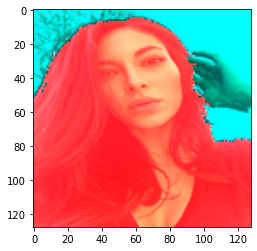

In [37]:
class MyDataset(Dataset):
  def __init__(self, data, mask, transform=True):
    self.data = data
    self.target = np.array([self.__encode__(m) for m in mask])
    self.N = self.data.shape[0]
    self.use_transform = transform
    self.transform = [self.__ident__, self.__rotate90__, self.__rotate270__, self.__horizontal_flip__]

  def __getitem__(self, idx):
    x = self.data[idx % self.N]
    y = self.target[idx % self.N]

    if self.use_transform:
      x, y = self.transform[idx // self.N](x, y)
    else:
      x, y = self.__ident__(x, y)

    return x, y

  def getitem_rotated(self, idx, angle):
    x = self.data[idx % self.N]
    y = self.target[idx % self.N]
    if angle == 90:
      return self.transform[1](x, y)
    return self.transform[2](x, y)

  def getitem_horizontal(self, idx):
    x = self.data[idx % self.N]
    y = self.target[idx % self.N]
    return self.transform[2](x, y)

  def __len__(self):
    return self.N * len(self.transform) if self.use_transform else self.N

  def __encode__(self, mask):
    H, W, _ = mask.shape
    target = np.zeros((H, W))
    target = (mask[:, :, 0] == 255)
    return target.astype(int) 

  def __rotate90__(self, pic, mask):
    return self.__rotate__(pic, mask, 90)
  
  def __rotate270__(self, pic, mask):
    return self.__rotate__(pic, mask, 270)

  def __rotate__(self, pic, mask, angle):
    from skimage.transform import rotate

    for index in range(3):
      channel = pic[:, :, index]
      channel = rotate(channel, angle, resize=False, preserve_range=True)
      pic[:, :, index] = channel

    mask = rotate(mask, angle, resize=False, preserve_range=True)
    return torch.from_numpy(pic), torch.from_numpy(mask).long()

  def __horizontal_flip__(self, pic, mask):
    pic = pic[:,::-1, :].copy()
    mask = mask[:,::-1].copy()
    return torch.from_numpy(pic), torch.from_numpy(mask).long()

  def __ident__(self, pic, mask):
    return torch.from_numpy(pic), torch.from_numpy(mask).long()
      

class Params:
    img_size = (128, 128)
    bs = 2
    num_workers = 4
    lr = 0.001
    epochs = 7
    unet_depth = 5
    wf = 3
    log_interval = 70.0 

train_path = '/content/drive/My Drive/MIM/dl_lab/ass2/gsn_img_uint8.npy'
test_path = '/content/drive/My Drive/MIM/dl_lab/ass2/test_gsn_image.npy'
train_mask = '/content/drive/My Drive/MIM/dl_lab/ass2/gsn_msk_uint8.npy'
test_mask_path = '/content/drive/My Drive/MIM/dl_lab/ass2/test_gsn_mask.npy'
best_model_path = '/content/drive/My Drive/MIM/dl_lab/ass2/model.pth'

trains = np.load(train_path)
masks = np.load(train_mask)
tests = np.load(test_path)
test_masks = np.load(test_mask_path)

train_dataset = MyDataset(trains, masks, False)
test_dataset = MyDataset(tests, test_masks, False)
trainloader = DataLoader(train_dataset, 
                         batch_size=Params.bs, 
                         shuffle=True, 
                         pin_memory=torch.cuda.is_available(),
                         num_workers=Params.num_workers)
testloader = DataLoader(test_dataset,
                        batch_size=Params.bs,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        num_workers=Params.num_workers)

def imshow(img, target):
  img[:,:,0] = 255 * target
  plt.imshow(img)
  plt.show()

images, targets = iter(trainloader).next()
imshow(images[0], targets[0])

## Train

In [38]:
model = UNet(num_classes=2, depth=Params.unet_depth, wf=Params.wf)
model.cuda()

def get_loss(dataloader, model):
  loss = 0
  total_train = 0
  correct_train = 0
  train_accuracy = 0
  for i, (img, mask) in enumerate(dataloader):
      img, mask = Variable(np.transpose(img.float(), (0,3,1,2))).cuda(), Variable(mask).cuda()
      output = model(img)
      loss += F.cross_entropy(output, mask).item()
      # returns index of max val in channel dimension (either 0 or 1)
      _, predicted = torch.max(output.data, dim=1)
      total_train += mask.nelement()
      correct_train += predicted.eq(mask.data).sum().item()
      train_accuracy += (100 * correct_train / total_train)
  loss = loss / len(dataloader)
  train_accuracy /= len(dataloader)
  return loss, train_accuracy


def train():
  it = 0
  iters = []
  losses = []
  test_losses = []
  min_loss = np.inf
  ious = []

  criterion = nn.CrossEntropyLoss()
  optim = torch.optim.Adam(model.parameters(), lr=Params.lr)
  
  model.train()
  for epoch in range(Params.epochs):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for i, (img, mask) in enumerate(trainloader):
      img, mask = Variable(np.transpose(img.float(), (0,3,1,2))).cuda(), Variable(mask).cuda() # [N, 3, H, W] <- [2, 128, 128, 3])
      output = model(img) # [N, 2, 128, 128]
      loss = criterion(output, mask)
      
      optim.zero_grad()
      loss.backward()
      optim.step()

      curr_loss = loss.item()
      running_loss += curr_loss
      if (i + 1) % Params.log_interval == 0:
        it += Params.log_interval * Params.bs
        iters.append(it)
        losses.append(curr_loss)

        print('[%d, %5d] Train loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / Params.log_interval))
        running_loss = 0.0

        model.eval()
        test_loss, accuracy = get_loss(testloader, model)
        model.train()
        test_losses.append(test_loss)
        print('Test pixel accuracy: %d %%' % (accuracy))
        if test_loss < min_loss:
          min_loss = test_loss
          torch.save(model.state_dict(), best_model_path)
        
        mask = mask.cpu().detach().numpy()
        output = output.cpu().detach().numpy()
        intersection = np.logical_and(mask, output)
        union = np.logical_or(mask, output)
        iou_score = np.sum(intersection) / np.sum(union)
        print('IoU score: %.3f' % (iou_score))
        ious.append(iou_score)

  return iters, losses, test_losses, ious
          
iters, losses, test_losses, ious = train()

[1,    70] Train loss: 0.645
Test pixel accuracy: 69 %
IoU score: 0.577
[1,   140] Train loss: 0.507
Test pixel accuracy: 74 %
IoU score: 0.812
[1,   210] Train loss: 0.455
Test pixel accuracy: 79 %
IoU score: 0.557
[1,   280] Train loss: 0.411
Test pixel accuracy: 78 %
IoU score: 0.711
[1,   350] Train loss: 0.365
Test pixel accuracy: 80 %
IoU score: 0.640
[1,   420] Train loss: 0.346
Test pixel accuracy: 79 %
IoU score: 0.625
[1,   490] Train loss: 0.341
Test pixel accuracy: 83 %
IoU score: 0.589
[1,   560] Train loss: 0.310
Test pixel accuracy: 79 %
IoU score: 0.751
[1,   630] Train loss: 0.295
Test pixel accuracy: 81 %
IoU score: 0.613
[1,   700] Train loss: 0.329
Test pixel accuracy: 83 %
IoU score: 0.655
[1,   770] Train loss: 0.303
Test pixel accuracy: 81 %
IoU score: 0.631
[1,   840] Train loss: 0.314
Test pixel accuracy: 82 %
IoU score: 0.609
[1,   910] Train loss: 0.276
Test pixel accuracy: 83 %
IoU score: 0.644
[1,   980] Train loss: 0.301
Test pixel accuracy: 83 %
IoU score

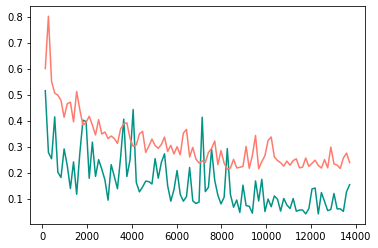

<Figure size 432x288 with 0 Axes>

In [39]:
plt.plot(iters, losses, color='xkcd:teal')
plt.plot(iters, test_losses, color='xkcd:salmon')
plt.show()
plt.savefig('/content/drive/My Drive/MIM/dl_lab/ass2/batch.png')

## Display some results


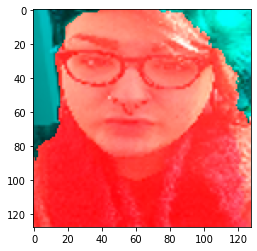

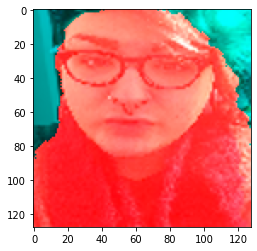

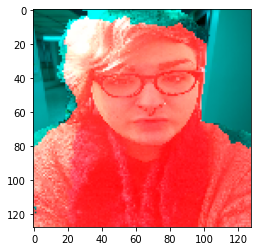

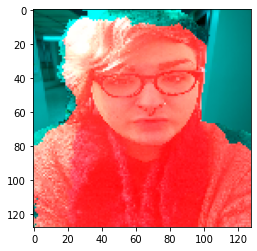

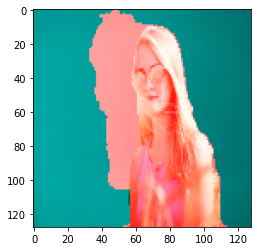

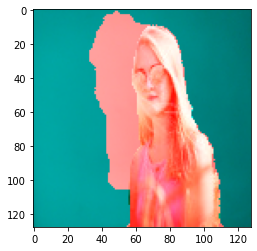

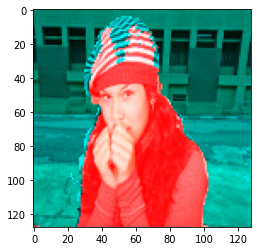

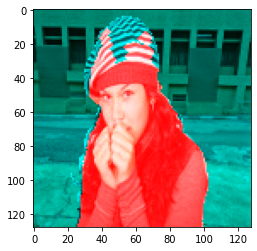

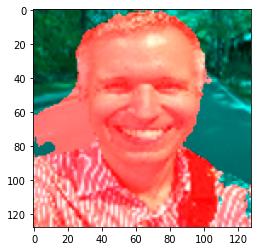

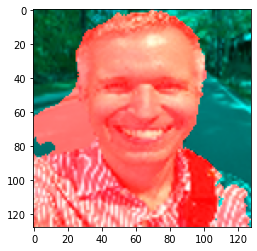

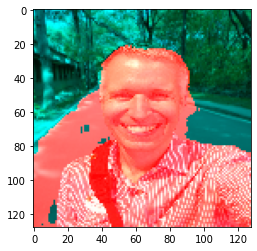

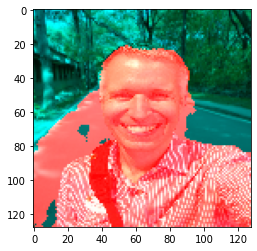

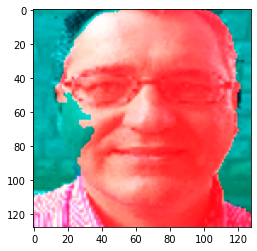

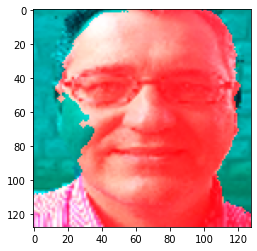

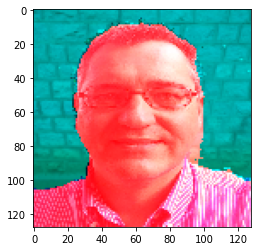

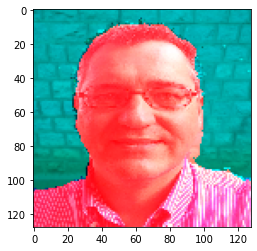

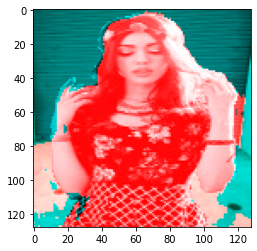

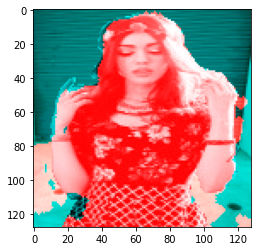

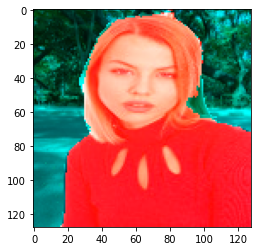

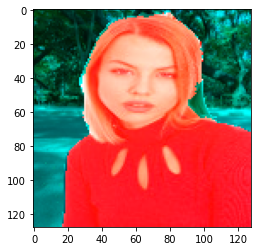

In [47]:
net = UNet(num_classes=2, depth=Params.unet_depth, wf=Params.wf)
net.cuda()
net.load_state_dict(torch.load(best_model_path))
test = iter(testloader)

def entropy(output):
  output = torch.sigmoid(output).data.cpu().numpy()
  # binary entropy function
  output = output * np.log2(output) + (1 - output) * np.log2(1 - output)
  return output.sum()

def count_false(output, mask):
  """
    output=1, mask=1 -> diff=0
    output=1, mask=0 -> diff=1 - false posit
    output=0, mask=1 -> diff=-1 - false negat
    output=0, mask=0 -> diff=0
  """
  diff = output.cpu() - mask
  on = torch.ones(diff.shape)
  return (diff == on).sum().item(), (diff == -on).sum().item()

def count_true(output, mask):
  diff = output.cpu() + mask
  tw = torch.ones(diff.shape) * 2
  return (diff == tw).sum().item(), (diff == tw - 2).sum().item()

N = 10
iters = [i for i in range(N)]
entropies = []
false = []
true = []

for i in range(N):
  images, targets = test.next()
  img = Variable(np.transpose(images.float(), (0,3,1,2))).cuda()
  output = net(img)
  entropies.append(entropy(output))

  _, predicted = torch.max(output.data, dim=1)
  false.append(count_false(predicted, targets))
  true.append(count_true(predicted, targets))
  mask = torch.sigmoid(output[0, 0]).data.cpu().numpy()
  mask = binary_opening(mask <= 0.5, disk(2))
  mask = torch.from_numpy(np.array(mask).astype(np.int8))
  imshow(images[0], mask)

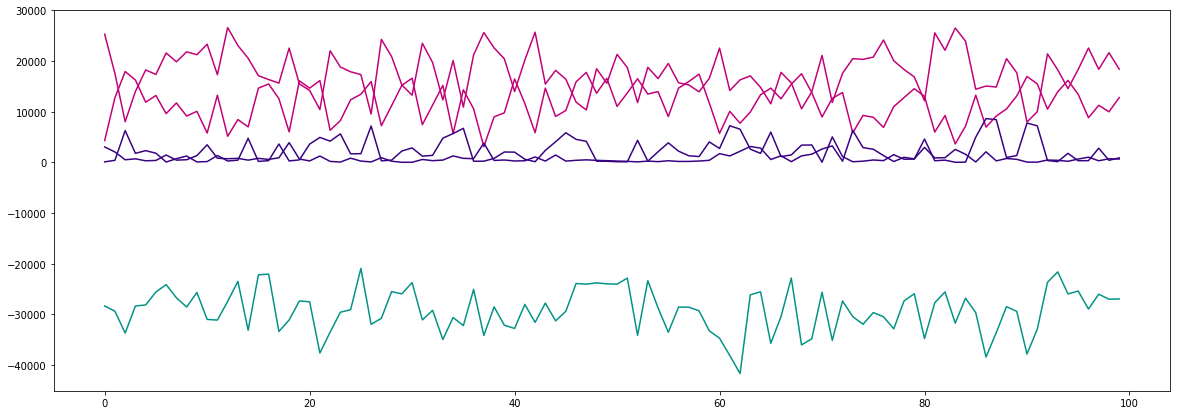

<Figure size 432x288 with 0 Axes>

In [41]:
fig = plt.figure(figsize=(20,7))
plt.plot(iters, entropies, color='xkcd:teal')
plt.plot(iters, true, color='xkcd:magenta')
plt.plot(iters, false, color='xkcd:indigo')
plt.show()
plt.savefig('/content/drive/My Drive/MIM/dl_lab/ass2/entropy.png')